### Imports

In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np
import pandas as pd
import h5py
import tables as pt
import random
import math
from __future__ import division

### Constants

In [2]:
# Paths
cwd = os.getcwd()
images_dir = os.path.join(cwd, 'images/')

# Storage
store = pd.HDFStore(cwd + '/store.h5')

### Create images info dataframe

In [3]:
# Group all images info in a single dataframe called all_images_df
labels = []
full_paths = []

# Get list of all images
images_filenames = os.listdir(images_dir)

# Add each image info to the all_images_df
for filename in images_filenames:
    label = ['cat', 'dog'].index(filename[:3])
    
    labels.append(label)
    full_paths.append(images_dir + filename)
    
images_df = pd.DataFrame({
        'label': labels,
        'full_path': full_paths
    })

In [4]:
images_df.tail()

,full_path,label
24995,/home/hugo/Desktop/cat-or-dog/images/cat.2679.jpg,0
24996,/home/hugo/Desktop/cat-or-dog/images/dog.4805.jpg,1
24997,/home/hugo/Desktop/cat-or-dog/images/cat.3345.jpg,0
24998,/home/hugo/Desktop/cat-or-dog/images/dog.9535.jpg,1
24999,/home/hugo/Desktop/cat-or-dog/images/cat.11227...,0


### Explore data

In [5]:
def add_size_to_image_df():
    widths = []
    heights = []
    ratios = []
    
    for index, row in images_df.iterrows():
        img_full_path = row['full_path']
        img = Image.open(img_full_path,'r')
        width, height = img.size
        widths.append(width)
        heights.append(height)
        ratios.append(float(width)/float(height))
    
    images_df['width'] = widths
    images_df['height'] = heights
    images_df['ratio'] = ratios

add_size_to_image_df()

In [6]:
images_df.head()

,full_path,label,width,height,ratio
0,/home/hugo/Desktop/cat-or-dog/images/dog.8010.jpg,1,174,223,0.780269
1,/home/hugo/Desktop/cat-or-dog/images/dog.4447.jpg,1,353,500,0.706000
2,/home/hugo/Desktop/cat-or-dog/images/cat.6824.jpg,0,350,261,1.340996
3,/home/hugo/Desktop/cat-or-dog/images/cat.11447...,0,500,374,1.336898
4,/home/hugo/Desktop/cat-or-dog/images/cat.4736.jpg,0,402,499,0.805611


In [7]:
def plot_height_repartition():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 2))
    ax1.plot(images_df['ratio'])
    ax1.set_title('Image size ratio : width/height')
    ax1.set_xlabel('Image index')
    ax1.set_ylabel('Ratio')
    print 'Average image ratio: {}'.format(np.mean(images_df['ratio']))
    
    ax2.plot(images_df['width'], images_df['height'], '.g')
    ax2.set_title('Image size')
    ax2.set_xlabel('Width in pixels')
    ax2.set_ylabel('Height in pixels')
    plt.show()

Average image ratio: 1.15719884542


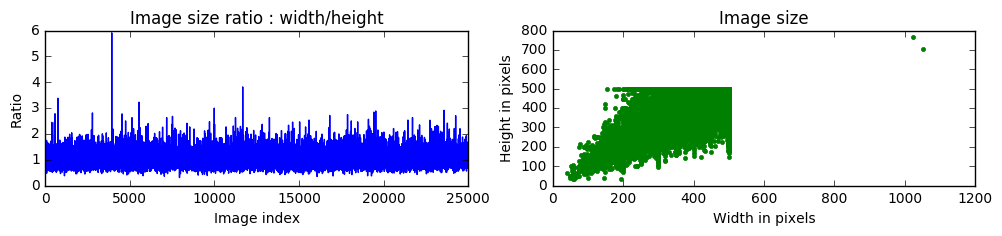

In [8]:
plot_height_repartition()

In [9]:
images_df[(images_df['height']>500) | (images_df['width']>500) ]

,full_path,label,width,height,ratio
6018,/home/hugo/Desktop/cat-or-dog/images/dog.2317.jpg,1,1050,702,1.495726
21062,/home/hugo/Desktop/cat-or-dog/images/cat.835.jpg,0,1023,768,1.332031


In [10]:
images_df[images_df['ratio']>3.5]

,full_path,label,width,height,ratio
3925,/home/hugo/Desktop/cat-or-dog/images/dog.4367.jpg,1,195,33,5.909091
11670,/home/hugo/Desktop/cat-or-dog/images/cat.9171.jpg,0,145,38,3.815789


In [11]:
# Remove outliers
images_df = images_df.drop([6018, 21062, 3925, 11670]).reset_index(drop=True)

Average image ratio: 1.15688184099


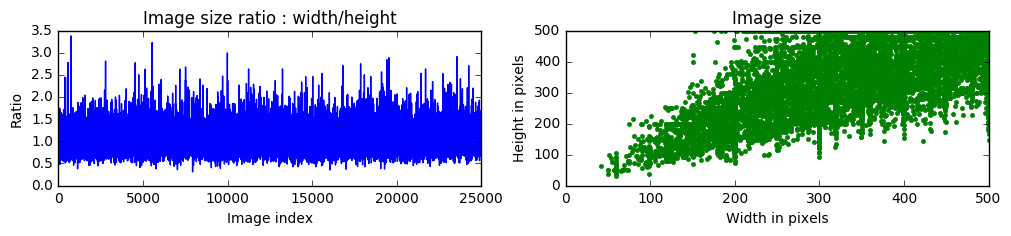

In [12]:
plot_height_repartition()

In [13]:
images_df.describe()

,label,width,height,ratio
count,24996.00000,24996.000000,24996.000000,24996.000000
mean,0.50000,404.067171,360.474116,1.156882
std,0.50001,108.879389,96.925833,0.289888
min,0.00000,42.000000,32.000000,0.306613
25%,0.00000,323.000000,301.000000,0.929810
50%,0.50000,447.000000,374.000000,1.270435
75%,1.00000,499.000000,420.250000,1.336898
max,1.00000,500.000000,500.000000,3.378378


### Split dataset

In [14]:
images_df = images_df.sort('label').reset_index(drop=True)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [15]:
# Split dataset randomly into training, validation and test set
train_images_nb = 20996
validation_images_nb = 2000
test_images_nb = 2000

def add_set_names_to_images_df():
    set_names = []
    cats_set_names = []
    dogs_set_names = []
    for _ in range(int(train_images_nb/2)):
        cats_set_names.append('train')
        dogs_set_names.append('train')
    for _ in range(int(validation_images_nb/2)):
        cats_set_names.append('validation')
        dogs_set_names.append('validation')
    for _ in range(int(test_images_nb/2)):
        cats_set_names.append('test')
        dogs_set_names.append('test')
        
    random.shuffle(cats_set_names)
    random.shuffle(dogs_set_names)
    
    print 'cats len:', len(cats_set_names)
    print 'dogs len:', len(dogs_set_names)
    
    set_names.extend(cats_set_names)
    set_names.extend(dogs_set_names)
    
    print len(set_names)
    images_df['set_name'] = set_names

add_set_names_to_images_df()

cats len: 12498
dogs len: 12498
24996


In [16]:
images_df.tail()

,full_path,label,width,height,ratio,set_name
24991,/home/hugo/Desktop/cat-or-dog/images/dog.661.jpg,1,240,179,1.340782,train
24992,/home/hugo/Desktop/cat-or-dog/images/dog.7429.jpg,1,399,500,0.798000,train
24993,/home/hugo/Desktop/cat-or-dog/images/dog.10948...,1,499,375,1.330667,train
24994,/home/hugo/Desktop/cat-or-dog/images/dog.2499.jpg,1,499,375,1.330667,train
24995,/home/hugo/Desktop/cat-or-dog/images/dog.8010.jpg,1,174,223,0.780269,test


### Save dataset

In [17]:
# Save images data
store['images_df'] = images_df
store.close()

In [18]:
print 'Total number of cats: {}'.format(len(images_df[images_df['label']==0]))
print 'Total number of dogs: {}'.format(len(images_df[images_df['label']==1]))

print 'Number of cats in training set: {}'.format(len(images_df[(images_df['label']==0) & (images_df['set_name']=='train')]))
print 'Number of dogs in training set: {}'.format(len(images_df[(images_df['label']==1) & (images_df['set_name']=='train')]))

print 'Number of cats in validation set: {}'.format(len(images_df[(images_df['label']==0) & (images_df['set_name']=='validation')]))
print 'Number of dogs in validation set: {}'.format(len(images_df[(images_df['label']==1) & (images_df['set_name']=='validation')]))

print 'Number of cats in test set: {}'.format(len(images_df[(images_df['label']==0) & (images_df['set_name']=='test')]))
print 'Number of dogs in test set: {}'.format(len(images_df[(images_df['label']==1) & (images_df['set_name']=='test')]))


Total number of cats: 12498
Total number of dogs: 12498
Number of cats in training set: 10498
Number of dogs in training set: 10498
Number of cats in validation set: 1000
Number of dogs in validation set: 1000
Number of cats in test set: 1000
Number of dogs in test set: 1000
